import packages for QRS detection

In [23]:
import datetime  # for runtime assessment
import numpy as np
from scipy.signal import detrend, butter, filtfilt, lfilter
from scipy.signal.windows import hamming
from scipy.ndimage import rank_filter
import matplotlib.pyplot as plt

import packages for example

In [24]:
import scipy.io

# QRS detection example

## Load ECG data from Matlab file

Download data in Matlab format from: https://zenodo.org/record/6967256/files/MIMIC_PERform_1_min_normal.mat?download=1
Then specify the path to this file here:

In [25]:
matlab_file_path = '/Users/petercharlton/Downloads/new_downloads/MIMIC_PERform_1_min_normal.mat'

Load ECG data from a .mat file

In [26]:
mat_data = scipy.io.loadmat(matlab_file_path)  # Replace with your file path

# Access the ECG signal and sampling frequency from the 'data' structure
ecg_signal = mat_data['data']['ekg'][0,0]['v'][0][0]  # 'v' contains the ECG signal
fs = mat_data['data']['ekg'][0,0]['fs'][0][0][0][0]  # 'fs' contains the sampling frequency

## Plot the ECG data

In [27]:
# Create a time vector for plotting
time = np.arange(len(ecg_signal)) / fs

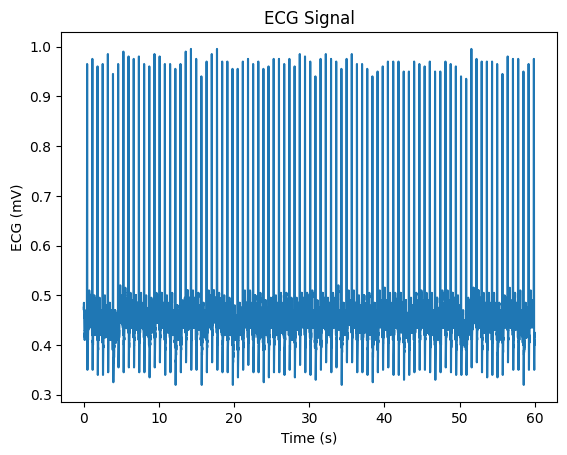

In [28]:
# Plot the ECG signal
plt.plot(time, ecg_signal)
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('ECG Signal')
plt.show()

## Run 'UNSW' QRS detector algorithm

In [29]:
import sys
sys.path.append('/Users/petercharlton/Documents/GitHub/unsw_python/src')
from UNSW_QRSDetector import UNSW_QRSDetector

In [30]:
unswdata = UNSW_QRSDetector(np.array(list(ecg_signal.T[0])),fs,mask=None,isplot=False)

You have not entered a mask. Continuing without.


In [31]:
unswdata['qrs'][0:10]

array([ 56, 143, 229, 315, 401, 487, 573, 659, 745, 831])

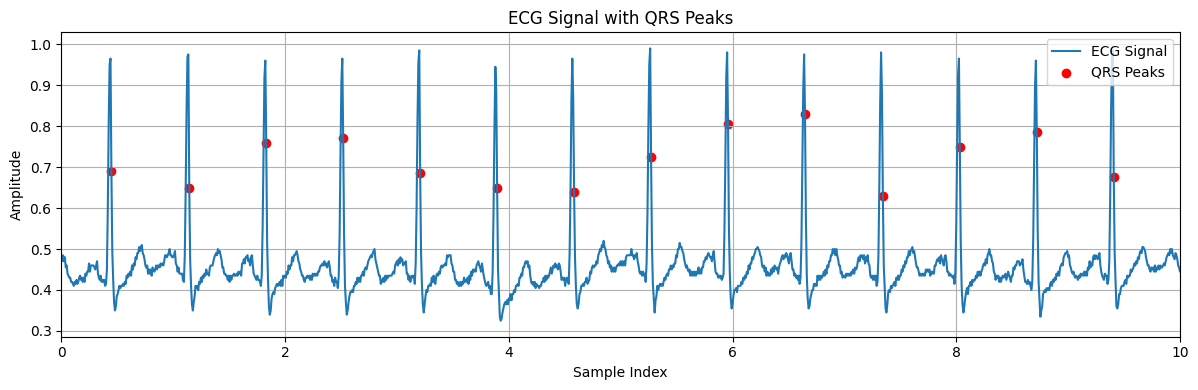

In [32]:
# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, label='ECG Signal')

# Plot the QRS peaks
plt.scatter(time[unswdata['qrs']], ecg_signal[unswdata['qrs']], color='red', label='QRS Peaks')

# Add labels and legend
plt.title('ECG Signal with QRS Peaks')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim([0, 10])
plt.show()
